# Mechanisms of Action (MoA) Prediction Challenge

![](https://media.cdn.lexipol.com/article-images/GettyImages-1153740646.jpg?w=300&format=jpg&quality=87)

This is a new tabular data competition recently started on Kaggle. This competition asks us to predict the action of drug sample based on gene expression & cell viability data. This competition is interesting because it provided me an opportunity to work on multilabel classification & Principal Component Analysis for the first time. This notebook is my attempt to make sense of the data through exploratory analysis & visualizations and establish a prediction benchmark using Random Forests. Please provide your feedback in the comments.

## Table of Contents

* [Making sense of Domain Specific Terminologies](#terminology)
* [Importing the raw datasets & basic overview of datasets](#introduction)
* [Distribution of Gene Expression & Cell Viability Variables](#gecv) 
* [Imapct of Drug Dosage & Interval on MoA](#dosage)
* [Mechanism of Action Variables](#moa) 
* [Principal Component Analysis for Dimensionality Reduction](#pca) 
* [Random Forest Benchmark model](#model) 


## Terminologies<a name="terminology"></a>

When I first started out in this competition I had a hard time making sense of all the terminologies related to Genetics since I don't come from a Biology background. Before diving deep into the data, let's first list out all the domain specific terms that will be mentioned multiple times later on in the notebook - 

* **Gene** - A gene is the basic physical and functional unit of heredity. Genes are made up of DNA. Every person has two copies of each gene, one inherited from each parent. Most genes are the same in all people, but a small number of genes (less than 1 percent of the total) are slightly different between people

* **Protein** - Proteins are large, complex molecules that play many critical roles in the body. They do most of the work in cells and are required for the structure, function, and regulation of the body’s tissues and organs.

* **Gene Expression** - Gene expression is the process by which the instructions in our DNA are converted into a functional product, such as a protein.Therefore, the thousands of genes expressed in a particular cell determine what that cell can do. A gene expression determines what kind of a function cell will perform in our body. 

* **Cell Viability** - Cell viability is a measure of the proportion of live, healthy cells within a population. Cell viability assays are used to determine the overall health of cells, optimize culture or experimental conditions, **and to measure cell survival following treatment with compounds, such as during a drug screen**.

* **Mechanism of Action** - In medicine, a term used to describe how a drug or other substance produces an effect in the body. For example, a drug’s mechanism of action could be how it affects a specific target in a cell, such as an enzyme, or a cell function, such as cell growth. Knowing the mechanism of action of a drug may help provide information about the safety of the drug and how it affects the body. It may also help identify the right dose of a drug and which patients are most likely to respond to treatment

Now that we have a better understanding of the domain specific terminologies that we will encounter in this dataset, let's import the datasets and dive deep into the data.



# Importing the Raw Datasets<a name="introduction"></a>

The Competiton provides the following files - 

```train_features.csv```- Features for the training set. Features ```g-``` signify gene expression data, and ```c-``` signify cell viability data. cp_type indicates samples treated with a compound (```cp_vehicle```) or with a control perturbation (```ctrl_vehicle```); **control perturbations have no MoAs**; ```cp_time``` and ```cp_dose``` indicate treatment duration (24, 48, 72 hours) and dose (high or low).

```test_features.csv``` - Features for the test data. We need to predict the probability of each scored MoA for each row in the test data

```train_targets_scored.csv``` - Output dataset. Contains 206 binary output variables, each signifying a specific MoA for each sample in the ```train_features``` dataset

```sample_submission.csv``` - The correct format for submissions. Reference the Evaluation tab for more info.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objects as go #Plotly for Viz
import plotly.express as px # Plotly express
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt #Matplotlib for Viz
import seaborn as sns #Seaborn for Viz
from scipy import stats #Outlier Analysis & Removal
from sklearn.decomposition import PCA #Dimensionality Reduction
from sklearn.preprocessing import StandardScaler #Scaling variables
from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.metrics import log_loss #Evaluation metric for the comp


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train_features=pd.read_csv('../input/lish-moa/train_features.csv')
test_features=pd.read_csv('../input/lish-moa/test_features.csv')
train_targets_scored=pd.read_csv('../input/lish-moa/train_targets_scored.csv')

In [ ]:
#Combining training and testing datasets
test_features['flag']='test'
train_features['flag']='train'

all_data = pd.concat([train_features, test_features], ignore_index=True, sort=False)
all_data

In [ ]:
train_features.describe()

In [ ]:
train_targets_scored

In [ ]:
train_features_scored=pd.merge(train_features,train_targets_scored,how='inner')
#train_features_scored

## Overview of Datasets 

### train_features
* sig_id - Refers to a unique sample in the dataset. Primary key for the dataset which links it to train_targets_scored dataset
* Gene Expression - Contains variables with ```g-``` prefix which store gene expression related information. There are about 775 gene expression variables. These variables generally have a mean around zero and range of -10 to 10
* Cell Viability - Contains variables with ```c-``` prefix which store cell viability information. There are about 100 cell viability variables. These variables also tend have a mean around zero and range of -10 to 5. The data contains negative values for Cell Viability as well, which does not make sense. We will investigate into this later
* Drug Dosage - Has distinct values for D1 & D2, signifying low and high dosage
* CP Time - Has three distinct values of 24, 28 and 72 hours
* CP Type - Indicates whether a sample has been treated with a compound or control perturbation

### train_targets_scored - 
Dataset containing the output variables for training data. There are about 206 binary output variables showing MoAs triggered for a specific sig_id. This dataset is linked to the train_features dataset through ```sig_id``` column 

### test_features
Test data on which our trained models have to make a prediction. 

Let's now take a deeper look at distribution of Gene Expression & Cell Viability Variables

# Distribution of Gene Expression & Cell Viability Variables <a name="gecv"></a>

In [ ]:
import random
#Plotting Histograms for Randomly Selected Gene Expression Variables
fig = make_subplots(
    rows=5, cols=4,shared_yaxes=True)
j=1
k=1

for i in range(1,21):
    rand=random.randint(0, 770)
    col="g-"+str(rand)
    fig.add_trace(
    go.Histogram(x=train_features[col],name=col),
    row=k, col=j
    )
   # print(k,j)
    j=j+1
    if(j>4):
        j=1
    if(i%4==0):
        k=k+1

        
fig.update_layout(title_text="Distribution for Randomly Selected Gene Expression Variables")
fig.show()

In [ ]:
fig = make_subplots(
    rows=20, cols=5,shared_yaxes=True)
j=1
k=1

for i in range(1,99):
    col="c-"+str(i)
    fig.add_trace(
    go.Histogram(x=train_features[col],name=col),
    row=k, col=j
    )
   # print(k,j)
    j=j+1
    if(j>5):
        j=1
    if(i%5==0):
        k=k+1

        
fig.update_layout(height=2500,width=800,title_text="Distribution for Cell Viability Rate variables")
fig.show()

Some observations from the plots above - 
* Both the Gene Expression & Cell Viability variables generally tend to follow a normal distrubtion centered around zero
* Gene Expression variables tend to have long left rail and right tail, indicating presence of outliers in the gene expression variables
* Cell Viability variables don't have a right skew but generally tend to have a long left tail, which points to negative cell viability rates. Since Cell Viability is the percentage of live cells in an environment, that number cannot be less than zero(you can't have negative live cells in a living organism). One reason for this could be that some sort of transformation has already been applied to the dataset and the mean centered around zero, therefore these values are actually transformed values and do not represent actual cell viability rates. 

Let's now look at correlation between Gene Expression & Cell Viability Rate Variables


In [ ]:
#Correlation matrix for Variables
# cell=train_features_scored.loc[:, train_features_scored.columns.str.startswith('g-')]
# corr = cell.corr(method='pearson')
# # corr
# f, ax = plt.subplots(figsize=(25, 25))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.8, cbar_kws={"shrink": .5})

# ax = sns.heatmap(corr,linewidths=0.8,cmap=cmap)


In [ ]:
#Correlation matrix for Variables
cell=train_features_scored.loc[:, train_features_scored.columns.str.startswith('c-')]
corr = cell.corr(method='pearson')
# corr
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

ax = sns.heatmap(corr,linewidths=0.8,cmap=cmap)


Heavy presence of red in the plot above suggests that cell viability variables are highly correlated to each other. This information will be helpful for us in dimensionality reduction because we will be able to combine some of these variables since they are highly correlated to each other. We will look at this detail again in PCA section of the notebook. 

# Impact of Drug Dosage, Treatment Duration & Drug Type on MoA <a name="dosage"></a>

In [ ]:
train_features_scored['sum_actions']=train_features_scored.iloc[:,-206:].sum(axis=1)
train_features_scored

fig = make_subplots(rows=3, cols=1,subplot_titles=('Sum of Drug Actions with different Dosages','Sum of Drug Actions with different Treatment Durations','Sum of Drug Actions with different Dosage Types'))
#fig = go.Figure()

fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_dose']=='D1','sum_actions'],name='Drug Dosage - D1'),row=1,col=1)
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_dose']=='D2','sum_actions'],name='Drug Dosage - D2'),row=1,col=1)
#fig.update_layout(title_text='Sum of Drug Actions with different Dosages',xaxis_title_text='Sum of Drug Actions',yaxis_title_text='Count of Samples')
#fig.show()

#fig1 = go.Figure()
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_time']==24,'sum_actions'],name='Treatment Duration - 24h'),row=2,col=1)
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_time']==48,'sum_actions'],name='Treatment Duration - 48h'),row=2,col=1)
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_time']==72,'sum_actions'],name='Treatment Duration - 72h'),row=2,col=1)
#fig.update_layout(title_text='Sum of Drug Actions with different Dosage Times',xaxis_title_text='Sum of Drug Actions',yaxis_title_text='Count of Samples')
#fig.show()

#fig2 = go.Figure()
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_type']=='trt_cp','sum_actions'],name='Drug Type - trt_cp'),row=3,col=1)
fig.add_trace(go.Histogram(x=train_features_scored.loc[train_features_scored['cp_type']=='ctl_vehicle','sum_actions'],name='Drug Type - ctl_vehicle'),row=3,col=1)
#fig2.update_layout(title_text='Distribution ofActions with different Dosage Types',xaxis_title_text='Sum of Drug Actions',yaxis_title_text='Count of Samples')
#fig2.show()

One thing that stands out is that neither of the three variables we looked at - Drug Dosage, Drug Type & Treatment Duration have any difference in distribution of sum of MoAs for distinct values of the variable. Therefore its unlikely that these features will play an important role in model development

One thing that was mentioned above and has been verified through the output is that records with ```ctrl_vehicle``` as ```cp_type``` do not have any MoAs. 

Another thing that can be observed is that majority of samples have 0 or 1 MoA associated with them. There are very few samples which have 2 or more MoAs associated with them 

# Dependent Variables - Mechanism of Action <a name="moa"></a>

Since this is a multilabel classfication problem, we have 206 binary dependent variables in the data, with individual columns for each MoA. We have to predict whether a particular gene expression & cell viability sample corresponds to a specific MoAs. One single drug sample can have multiple mechanism of actions. 

For the charts below, we summed up the values of individual MoAs to understand which MoAs are most & least commonly triggered in the dataset. 

In [ ]:
depsum=train_features_scored.iloc[:,-206:-1].sum(axis=0)
depsum=depsum.to_frame()
depsum.columns=['sum_actions']
depsum['action']=depsum.index
depsum=depsum.reset_index(drop=True)
depsum=depsum.sort_values(by='sum_actions',ascending=False)
depsum_top=depsum.head(10)
depsum_tail=depsum.tail(10)

import plotly.express as px
# df = px.data.tips()
fig2 = px.histogram(depsum, x="sum_actions",opacity=0.6, title='Histogram of Sum of Actions across MoAs')
fig2.show()




In [ ]:
fig=px.bar(depsum_top,y='sum_actions',x='action',title='Most Common MoAs')
#fig.update_layout(height=350,width=800)
fig.show()

fig1=px.bar(depsum_tail,y='sum_actions',x='action',title='Least Common MoAs')
#fig1.update_layout(height=350,width=800)

fig1.show()

Here are some of the observations from the plots above - 
* The histogram for sum of actions across different MoAs is left skewed. Majority of MoAs have less than 100 samples where they were triggered. This is quite low given that we have almost 23k samples in our training dataset. 
* nfkb_inhibitor & proteasome_inhibitor are the most common MoAs with counts of around 800+ and 700+ respectively
* Other popular MoAs for Cyclooxygenase_inhibitor, dopamine_receptor_antagonist, dna_inhibitor etc. have counts of 400+ records each
* Least common MoAs like steroid, elastase_inhibitor, laxative have less than 10 records each
* Each MoA has been triggered atleast once in the data
* Given the low triggers for some of the MoAs, it may be an interesting approach to set their predictions manually to zero and ignore them from the prediction. 

Next we would look at correlation between MoAs to understand if a drug sample is likely to trigger multiple MoAs that are correlated to each other. 

In [ ]:
actions=train_features_scored.iloc[:,-100:]
corr = actions.corr(method='pearson')
# corr
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .5})

ax = sns.heatmap(corr,linewidths=0.8,cmap=cmap)


The above correlation plot tells us that there is no correlation across MoAs, meaning that these MoAs are independent to each other and triggering of one MoA is unlikely to lead to triggering of other MoA because of zero correlation. 

# Dimensionality Reduction - Principal Component Analysis <a name="pca"></a>

In our data we have about 775 gene expression variables and 100 cell viability variables and 23000+ records in the training dataset. Building an ensemble learning model on this dataset would take a large amount of time, and also we noticed that a lot of cell viability variables are correlated to each other. Therefore we would be looking at dimensionality reduction to overcome these issues. Here we would be implementing Principal Component Analysis(PCA) to achieve dimensionality reduction.
According to the link [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) - 
>   Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

#### When to use PCA?
* When we want to reduce the number of independent variables but still don't want to lose the information available from those variables. 
* When we want to ensure our variables are independent of each other
* When we are comfortable with making our independent variables less interpretable

#### Steps we will follow to implement PCA - 
* Remove outliers and standardize the variables
* Covariance Matrix  computation and calculation of Eigen Values. The PCA function in sklearn package takes care of these details and we don't have to worry about them
* Plot the explained variance by Principal Components and select the number of principal components to include. 

Please watch [this](https://www.youtube.com/watch?v=FgakZw6K1QQ) great video on Youtube if you would like to learn in detail about how PCA actually works. 

#### Remove outliers and standardizing the dataset

In [ ]:
#Capping outliers
def cap_outliers(col):
    col[col>3]=3
    col[col<-3]=-3
    return col

In [ ]:
#Filtering all the numeric columns
numcols=all_data._get_numeric_data().columns
all_data_num=all_data.loc[:,numcols]
all_data_num=all_data_num.iloc[:,1:]

#z=np.abs(stats.zscore(all_data_num['g-0']))
#Calculate Z Scores for all the variables. 
all_data_num=all_data_num.apply(stats.zscore)

#Cap the outliers
all_data_num=all_data_num.apply(cap_outliers)
#all_data_num.describe()
#z


#### Calculating Principal Components

In [ ]:
# Function to implement PCA
def pca_application(df,n_components,pattern):
    df_p=df.loc[:, df.columns.str.startswith(pattern)]
    x = StandardScaler().fit_transform(df_p)
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents)
    return principalDf,pca

In [ ]:
#Calculate principal components separately for GE & CV columns
principalDf_g,pca_g=pca_application(all_data,200,'g-')
principalDf_c,pca_c=pca_application(all_data,30,'c-')

#principalDf_g

#### Selecting ideal number of Principal Components based on Explained Variance Plots

In [ ]:
z=np.arange(start=1, stop=len(pca_g.explained_variance_ratio_)+1, step=1)
z

plt.bar(x=z,height=pca_g.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')
plt.title('Explained Variance for Gene Expression Variable PCAs')
plt.show()

plt.plot(np.cumsum(pca_g.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for Gene Expression Variable PCAs')


In [ ]:
z=np.arange(start=1, stop=len(pca_c.explained_variance_ratio_)+1, step=1)
z

plt.bar(x=z,height=pca_c.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')
plt.title('Explained Variance for Cell Viability Variable PCAs')
plt.show()

plt.plot(np.cumsum(pca_c.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for Cell Viability Variable PCAs')


In the cells above we implemented PCA and plotted the Explained Variance plots. In the plots above we would be looking to identify the points where the curve tends to flatten a bit i.e. adding the number of principal components does not add the cumulative explained variance significantly. 

Looking at the plots above we would be selecting 100 PCs for Gene Expression Variables and 10 PCs for Cell Viability Variables.

Also majority of the variance in the GE & CV columns were expressed by the first few principal components, as is generally the case with PCA. Since the CV columns were highly correlated to each other, we require fewer PCs to explain the variance emanating from those columns. 

In [ ]:
#Extracting the principal components
pca_g=principalDf_g.iloc[:,:100]
l=[]
for i in range(1,101):
    var='pca_g'+str(i)
    l.append(var)
#l
pca_g.columns=l
pca_g


In [ ]:
#Extracting the principal components
pca_c=principalDf_c.iloc[:,:10]
#pca_c.columns=['pca_c1','pca_c2','pca_c3','pca_c4','pca_c5']
#pca_c
l=[]
for i in range(1,11):
    var='pca_c'+str(i)
    l.append(var)
#l
pca_c.columns=l
pca_c

#Merging the principal components dataframes
pca_cg=pd.merge(pca_c, pca_g, left_index=True, right_index=True)
pca_cg

In [ ]:
cp_cols=all_data.iloc[:,1:4]
pca_cg_cp=pd.merge(cp_cols, pca_cg, left_index=True, right_index=True)
pca_cg_cp['flag']=all_data['flag']


In [ ]:
#pca_cg_cp=pca_cg_cp.loc[pca_cg_cp['cp_type']!='ctl_vehicle',:]
#train_features_scored=train_features_scored.loc[train_features_scored['cp_type']!='ctl_vehicle',:]

#Calculating dummies for categorical variables
pca_cg_cp=pd.get_dummies(pca_cg_cp, columns=['cp_type', 'cp_dose'])
pca_cg_cp

# Model Building - Ensemble Models <a name="model"></a>

In the steps below we would be fitting a few basic Random Forest, XGBoost & Logistic Regression models on the training dataset and looking at feature importance matrix to understand which variables contribute most to the prediction power of the model. I selected RF because it is one of the models which can be directly used as a Multilabel Classifier from the sklearn package. Here is the [link](https://scikit-learn.org/stable/modules/multiclass.html) which explains more about Multilabel & Multiclass Classifiers in detail. XGBoost & Logistic Regression models don't support Multilabel Classification out of the box and we would have to wrap them in MultiOutput Classifiers for this problem. We would essentially be training 206 different XGBoost & Logisitc models while using the MultiOutput Classifier wrappers. 


#### Evaluation Metric - Log Loss
The eveluation metric for this competition is Log Loss. The formula for computation of Log Loss metric is below - 
![](https://media.geeksforgeeks.org/wp-content/uploads/20190620132533/LogLoss.jpg)


* N  : no. of samples.
* M  : no. of attributes.
* xij : indicates whether ith sample belongs to jth class or not.
* pij : indicates probability of ith sample belonging to jth class.

As the predicted probability of the true class gets closer to zero, the loss increases exponentially:

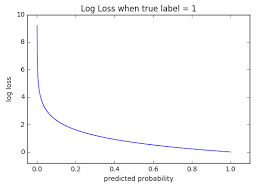


Please go through this excellent [link](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) if you want to understand more in detail about the math behind computation of log loss and how it works. 

In [ ]:
pca_cg_cp_train=pca_cg_cp.loc[pca_cg_cp['flag']=='train',:]
pca_cg_cp_train
del pca_cg_cp_train['flag']

In [ ]:
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

X=pca_cg_cp_train #Selecting feature variables
Y=train_features_scored.iloc[:,-207:-1] #Selecting the output columns
feature_list=pca_cg_cp_train.columns

#Split data into train and test datasets
X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)


#MLSMOTE - https://www.kaggle.com/tolgadincer/upsampling-multilabel-data-with-mlsmote
def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices


def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target



In [ ]:
X_sub, y_sub = get_minority_samples(X_train, Y_train)  # Getting minority samples of that datframe
X_res, y_res = MLSMOTE(X_sub, y_sub, 1000, 5)  # Applying MLSMOTE to augment the dataframe

#print(X_res.shape,y_res.shape)


In [ ]:
X_train=X_train.append(X_res,ignore_index=True)
Y_train=Y_train.append(y_res,ignore_index=True)

print(X_train.shape,Y_train.shape)


In [ ]:
#Y_train.sum(axis=0).sort_values(ascending=False).tail(20)


In [ ]:
#Y_train1.sum(axis=0).sort_values(ascending=False).tail(20)


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

# X=pca_cg_cp_train #Selecting feature variables
# Y=train_features_scored.iloc[:,-207:-1] #Selecting the output columns
# feature_list=pca_cg_cp_train.columns

# #Split data into train and test datasets
# #X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)
# #X_train,Y_train,X_test,Y_test=train_test_split(X, Y,test_size=0.3)

model = RandomForestClassifier(n_estimators=200,max_depth=10, random_state=0,min_samples_split=10)
model.fit(X_train,Y_train)#Fitting the model 



#Generating predictions from Random Fores Models
pred_rf=model.predict(X_test)
pred_rf_proba=model.predict_proba(X_test)

feat_importances = pd.Series(model.feature_importances_, index=feature_list)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model.score(X_test,Y_test))


In [ ]:
from skmultilearn.model_selection import IterativeStratification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

log_model= MultiOutputClassifier(LogisticRegression(max_iter=10000, tol=0.1, C = 0.5,verbose=0,random_state = 42))

# def fit_model(X,Y,model):

#     k_fold = IterativeStratification(n_splits=3, order=1)
#     for train, test in k_fold.split(X, Y):
#         print(X.iloc[train].shape, Y.iloc[test].shape)
#         model.fit(X.iloc[train], Y.iloc[train])
#         preds = model.predict_proba(X.iloc[test])
#         preds=pred_transform(preds)
#         score = log_loss(np.array(Y.iloc[test]),preds)
#         print('LogLoss Score:', score)

# fit_model(X,Y,log_model)

Following things are observable from the plot above - 
* The first principal components for c- and g- variables have the highest feature importance
* As observed in our EDA - dosage, treatment type and duration of treatment have the lowest feature importance in the dataset. c- and g- PCs solely contribute to the performance of the model. 

#### Error Analysis
We would analyze the log loss by individual clases to understand the areas our model is performing good and bad. 

In [ ]:
#Helper Functions

def Extract(lst): 
    return [item[:,1] for item in lst] 

def calc_loss_df(pred_proba):
    out=Extract(pred_proba)
    arr=np.array(out)
    arr1=np.transpose(arr)
    l=[]
    col=[]
    testcols=Y_test.columns
    y=np.array(Y_test)
    
    for i in range(0,206):
        a=arr1[:,i].astype('float')
        b=y[:,i].astype('int')
        if np.sum(b)>0:
            l.append(log_loss(b,a))
            col.append(testcols[i])

    err=pd.DataFrame(
        {'cols': col,
         'log_loss': l
        })
    err=err.sort_values(by='log_loss',ascending=False)
    return err  

def pred_transform(preds):
    out=Extract(preds)
    arr=np.array(out)
    arr1=np.transpose(arr)
    return arr1

In [ ]:
from sklearn.metrics import log_loss
pred_rf_proba_t=pred_transform(pred_rf_proba)

print(log_loss(np.array(Y_test),np.array(pred_rf_proba_t)))#Compute Log loss


In [ ]:
# Calculating Log Loss by Individual Output Column
#y=np.array(Y_test)

err=calc_loss_df(pred_rf_proba)

err_head=err.head(10)
err_tail=err.tail(10)

fig2 = px.histogram(err, x="log_loss",opacity=0.6, title='RF - Distribution of Log Loss values on test dataset')
fig2.show()

fig=px.bar(err_head,x='cols',y='log_loss',title='RF - Output Variables with Highest Log Loss')
fig.show()

fig1=px.bar(err_tail,x='cols',y='log_loss',title='RF - Output Variables with Lowest Log Loss')
fig1.show()

* The histogram for Log loss values for individual columns has a long right tail. There are about 15 columns having Log loss higher than 0.05
* The peak for histogram is around the log loss range of 0.005-0.009
* **Cyclooxygenase Inhibitor** has the highest log loss value of >0.10, which shows that our model is not performing well in predicting this column. 

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier


log_model= MultiOutputClassifier(LogisticRegression(max_iter=10000, tol=0.1, C = 0.5,verbose=0,random_state = 42))
log_model.fit(X_train,Y_train)#Fitting the model 
#log_model.fit(X_res,y_res)
#Generating predictions
pred_log_proba=log_model.predict_proba(X_test)
pred_log_proba_t=pred_transform(pred_log_proba)


In [ ]:
#Compute Log loss for Logistic Regression
print(log_loss(np.array(Y_test),pred_log_proba_t))


### XGBoost

In [ ]:
import xgboost
from xgboost import XGBClassifier
# xgb = MultiOutputClassifier(xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=1,
#                            colsample_bytree=0.75, max_depth=12))
# xgb.fit(X_train,Y_train)
                            

In [ ]:
# Using parameters from https://www.kaggle.com/fchmiel/xgboost-baseline-multilabel-classification
xgb = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))

params = {'estimator__colsample_bytree': 0.6522,
          'estimator__gamma': 3.6975,
          'estimator__learning_rate': 0.0503,
          'estimator__max_delta_step': 2.0706,
          'estimator__max_depth': 10,
          'estimator__min_child_weight': 31.5800,
          'estimator__n_estimators': 166,
          'estimator__subsample': 0.8639
         }

xgb.set_params(**params)
xgb.fit(X_train,Y_train)


In [ ]:
pred_xg_proba = xgb.predict_proba(X_test)
df_ll_xg=calc_loss_df(pred_xg_proba)
pred_xg_proba_t=pred_transform(pred_xg_proba)

print(log_loss(np.array(Y_test),pred_xg_proba_t))


In [ ]:
df_ll_log=calc_loss_df(pred_log_proba)
#print('Log Loss for Logistic Regression',df_ll_log)

fig = go.Figure()
fig.add_trace(go.Histogram(x=err['log_loss'],name='Random Forest'))
fig.add_trace(go.Histogram(x=df_ll_log['log_loss'],name='Logistic Regression'))
fig.add_trace(go.Histogram(x=df_ll_xg['log_loss'],name='XGBoost'))

fig.update_layout(barmode='overlay',title='Comparison of Distribution of Log Loss values for models')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.6)

fig.show()

In [ ]:
loss_actions_r=pd.merge(left=depsum,right=err,how='inner',left_on='action',right_on='cols')
loss_actions_r.columns=['sum_actions','action','cols','log_loss_rf']

loss_actions_r_x=pd.merge(left=loss_actions_r,right=df_ll_xg,how='inner')
loss_actions_r_x.columns=['sum_actions','action','cols','log_loss_rf','log_loss_xg']
#loss_actions_r_x

loss_actions_r_x_l=pd.merge(left=loss_actions_r_x,right=df_ll_log,how='inner')
loss_actions_r_x_l.columns=['sum_actions','action','cols','log_loss_rf','log_loss_xg','log_loss_logistic']
loss_actions_r_x_l

fig=go.Figure()
fig.add_trace(go.Scatter(x=loss_actions_r_x_l['sum_actions'],
                        y=loss_actions_r_x_l['log_loss_rf'],mode='markers',name='Random Forest'))
fig.add_trace(go.Scatter(x=loss_actions_r_x_l['sum_actions'],
                        y=loss_actions_r_x_l['log_loss_xg'],mode='markers',name='XGBoost'))
fig.add_trace(go.Scatter(x=loss_actions_r_x_l['sum_actions'],
                        y=loss_actions_r_x_l['log_loss_logistic'],mode='markers',name='Logistic Regression'))

fig.update_layout(title='Model Performance - Sum of MoAs for Dependent Variable in Train dataset vs Log Loss',xaxis_title='Sum of MoAs Output Variable',yaxis_title='Log Loss value for Output Variable')

fig.show()

* Distribution of MoA values for all three models seems to be similar, with RF having the shortest right tail
* Sum of MoAs seems to have a positive correlation with log loss values. This shows us that class imbalance plays a role here and **our models do not do well for columns which have a high proportion of zeros**.



In [ ]:
pca_cg_cp_test=pca_cg_cp.loc[pca_cg_cp['flag']=='test',:]
del pca_cg_cp_test['flag']
#pca_cg_cp_test

#preds=model.predict(pca_cg_cp_test)
#for i in range(1:207)


In [ ]:
#Final Predictions 
preds_rf=model.predict_proba(pca_cg_cp_test)
preds_xg=xgb.predict_proba(pca_cg_cp_test)
preds_log=log_model.predict_proba(pca_cg_cp_test)

def pred_transform(preds):
    out=Extract(preds)
    arr=np.array(out)
    arr1=np.transpose(arr)
    return arr1

#Calculate & Transform predictions for individual models 
preds_rf=pred_transform(preds_rf)
preds_xg=pred_transform(preds_xg)
preds_log=pred_transform(preds_log)



In [ ]:
comb_preds=np.mean([preds_rf,preds_log,preds_xg],axis=0)

In [ ]:
df = pd.DataFrame(data=comb_preds)
sample_submission=pd.read_csv('../input/lish-moa/sample_submission.csv')

df.insert(loc=0, column='sig_id', value=test_features['sig_id'])
df.columns=sample_submission.columns

df['cp_type']=test_features['cp_type']
#Manually setting the predictions as zero for ctl_vehicle records
df.iloc[df['cp_type']=='ctl_vehicle',1:207]=0
del df['cp_type']

#df.to_csv('chk.csv',index=False)
#Writing the submission csv file
df.to_csv('submission.csv',index=False)


## Next Steps - 

* Gain domain expertise to perform intelligent Feature Engineering
* Improve performance of Dimensionality Reduction technique
* Test more prediction techniques, use MultiOutput Classifiers, NN etc.